In [69]:
import matplotlib.pyplot as plt
import numpy as np
from mpl_toolkits.axes_grid1 import make_axes_locatable

plt.rcParams.update({"font.family": "Times New Roman", "mathtext.fontset": "cm", "lines.linewidth": 1})
pi = np.pi
sqrt = np.sqrt

Tomaré $L = 1$ y variaré $R_1, R_2$ para encontrar las regiones de estabilidad con $g_i = 1 - L / R_i$.

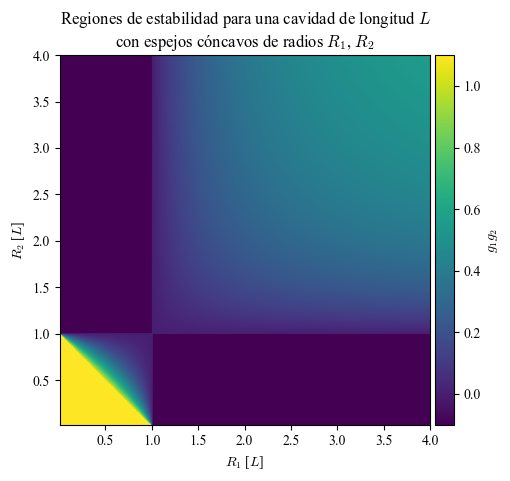

In [242]:
L = 1
step = 0.01
R2, R1 = np.mgrid[4*L:step:-step, step:4*L + step:step]

g1 = 1 - L / R1
g2 = 1 - L / R2
g1g2 = g1*g2
g1g2[g1g2 < 0] = -0.1
g1g2[g1g2 > 1] = 1.1

fig, ax = plt.subplots()

title = "Regiones de estabilidad para una cavidad de longitud $L$\n" \
        "con espejos cóncavos de radios $R_1$, $R_2$"
ax.set(title=title,
       xlabel="$R_1$ [$L$]", ylabel="$R_2$ [$L$]")
im = ax.imshow(g1g2, extent=[np.min(R1), np.max(R1), np.min(R2), np.max(R2)])
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.05)
plt.colorbar(im, cax=cax, label="$g_1g_2$")

plt.savefig("stability.png", dpi=300)

Observamos que la cavidad es estable para todos los radios con $R_1$, $R_2 > L$. Por lo que tomaré $R_1 = 1.5L$, $R_2 = 3L$ para simular la propagación del haz en la cavidad.

Para la condición inicial $q_0$ usamos el valor de $q$ obtenido de la condición de autoconsistencia tras una vuelta completa en la cavidad:

$$\frac{1}{q} = \frac{D - A}{2 B} - i \frac{\sqrt{1 - \left(\frac{D + A}{2}\right)^2}}{|B|}.$$

Siendo los parámetros $A$, $B$, $C$, $D$ las entradas de la matriz de transmisión en el viaje completo.

In [244]:
def free_matrix(z):
    return np.array([[1, z], [0, 1]])

def mirror_matrix(R):
    return np.array([[1, 0], [-2/R, 1]])

def get_ABCD(M):
    return M[0, 0], M[0, 1], M[1, 0], M[1, 1]

def get_q0(L, R1, R2):
    one_trip_matrix = mirror_matrix(R1)@free_matrix(L)@mirror_matrix(R2)@free_matrix(L)
    A, B, C, D = get_ABCD(one_trip_matrix)
    q_inv = (D - A) / 2*B - 1j * (sqrt(1 - (D + A)**2 / 4) / np.abs(B))
    return 1 / q_inv

@np.vectorize
def get_q(q0, d, L, R1, R2):
    d = d % (2*L)
    if d < L:
        A, B, C, D = get_ABCD(free_matrix(d))
    if d >= L and d < 2*L:
        A, B, C, D = get_ABCD(free_matrix(d - L)@mirror_matrix(R2)@free_matrix(L))
    if d >= 2*L:
        A, B, C, D = get_ABCD(free_matrix(d - 2*L)@mirror_matrix(R1)@free_matrix(L)@mirror_matrix(R2)@free_matrix(L))
    q = (A*q0 + B) / (C*q0 + D)
    return q

def get_R(q):
    return 1 / np.real(q**(-1))

def get_w(q, wl, n=1):
    return np.sqrt(-wl / (n * pi * np.imag(q**(-1))))

def get_zR(w0, wl):
    return pi * w0**2 / wl

def get_phi(d, L, z0, zR):
    z = d % (2*L)
    return np.arctan((z - z0) / zR)

In [245]:
L, R1, R2 = 10, 15, 30 # mm
wl = 780E-6 # mm
d = np.arange(0, 2.5*L, 0.001) # mm
q0 = get_q0(L, R1, R2)

q = get_q(q0, d, L, R1, R2)
R = get_R(q)
w = get_w(q, wl)

min_index = np.argmin(w)
w0 = np.min(w)
z0 = d[min_index]
zR = get_zR(w0, wl)
phi = get_phi(d, L, z0, zR)

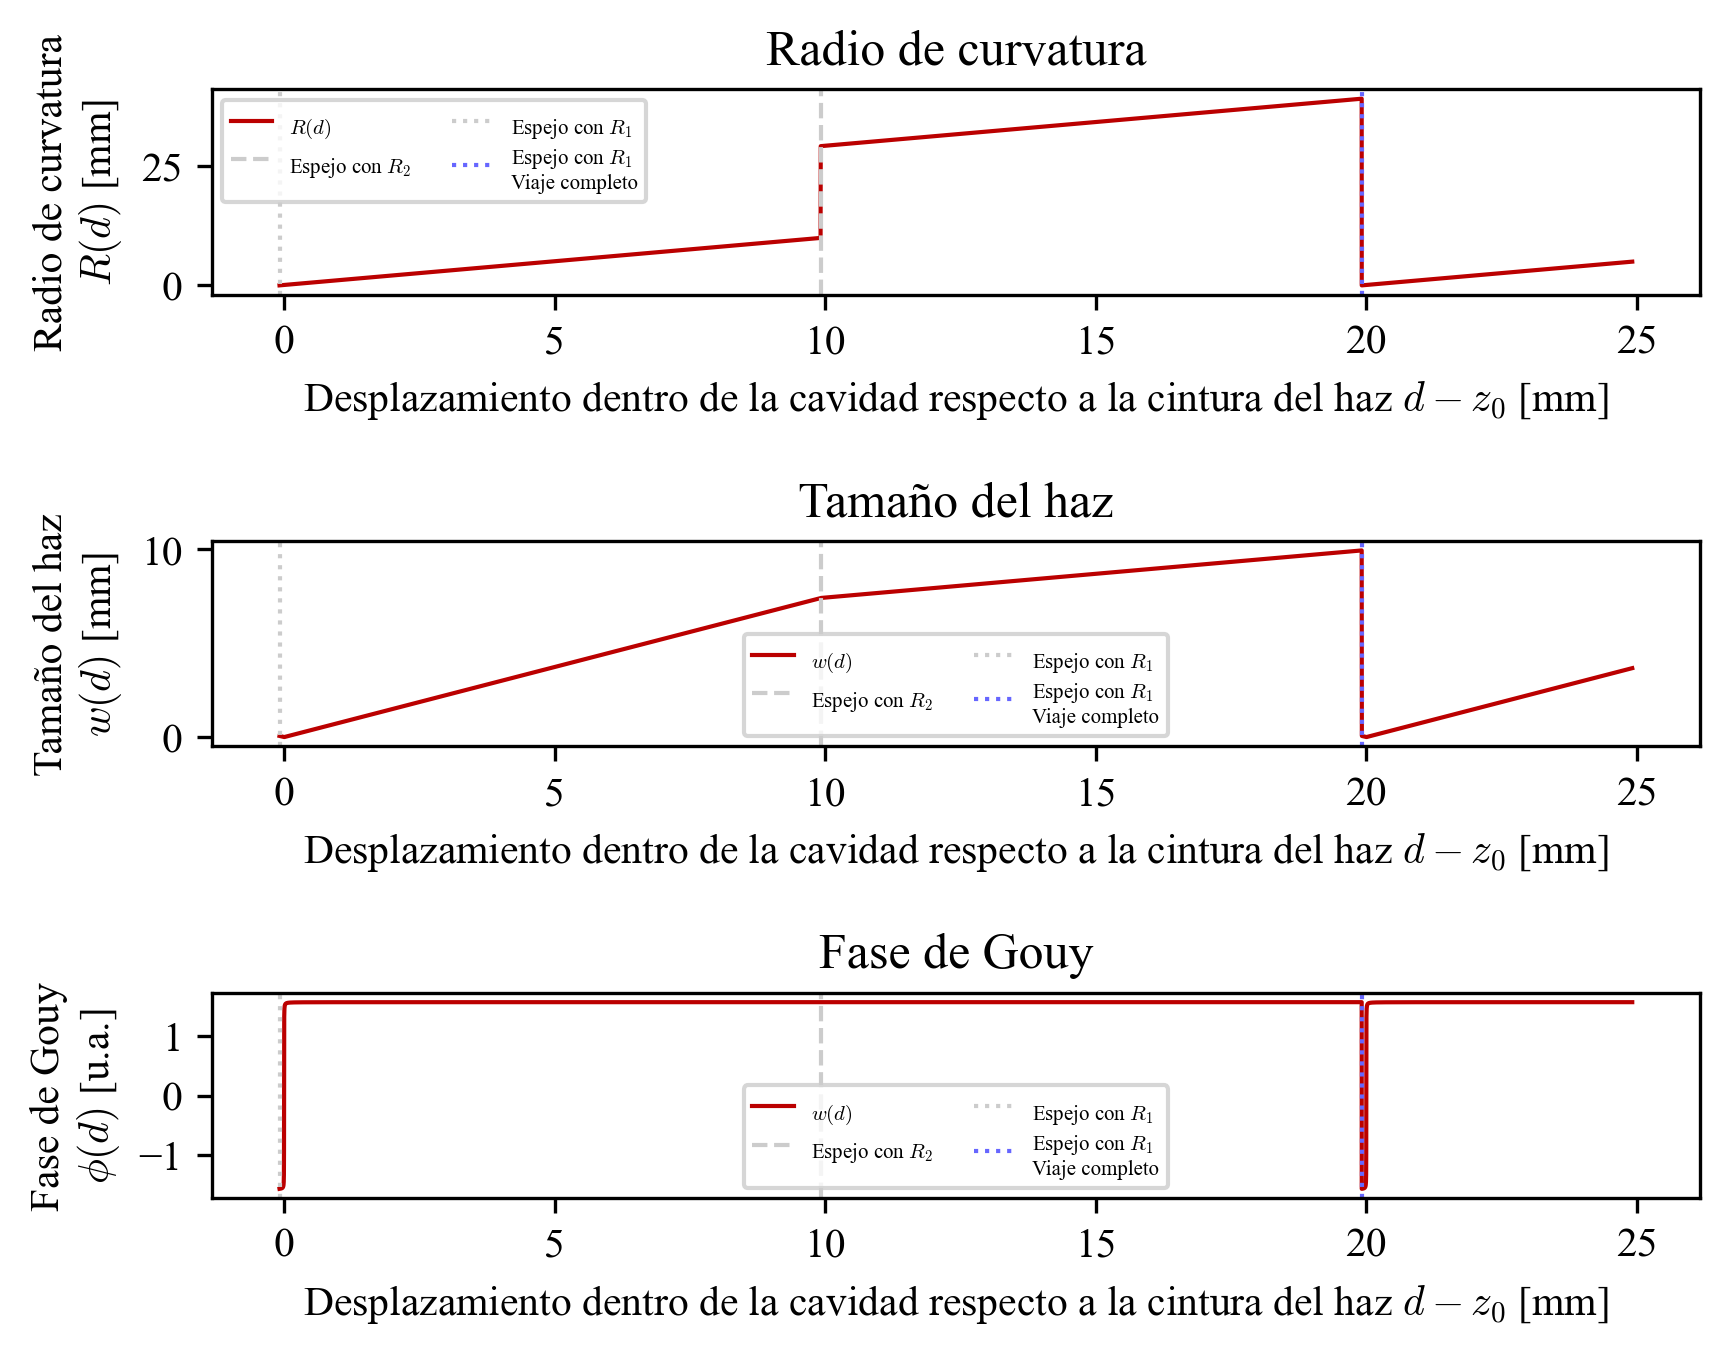

In [246]:
fig, axs = plt.subplot_mosaic([["R"], ["w"], ["phi"]], dpi=300)

xlabel = "Desplazamiento dentro de la cavidad respecto a la cintura del haz $d - z_0$ [mm]"
axs["R"].set(xlabel=xlabel, ylabel="Radio de curvatura\n$R(d)$ [mm]",
             title="Radio de curvatura")
axs["w"].set(xlabel=xlabel, ylabel="Tamaño del haz\n$w(d)$ [mm]",
             title="Tamaño del haz")
axs["phi"].set(xlabel=xlabel, ylabel="Fase de Gouy\n$\phi(d)$ [u.a.]",
             title="Fase de Gouy")

axs["R"].plot(d - z0, R, color="#b00", label="$R(d)$")
axs["w"].plot(d - z0, w, color="#b00", label="$w(d)$")
axs["phi"].plot(d - z0, phi, color="#b00", label="$w(d)$")

for ax_label in axs:
    axs[ax_label].axvline(L - z0, color="#ccc", ls="--", label="Espejo con $R_2$")
    axs[ax_label].axvline(-z0, color="#ccc", ls=":", label="Espejo con $R_1$")
    axs[ax_label].axvline(2*L-z0, color="#66f", ls=":", label="Espejo con $R_1$\nViaje completo")
    axs[ax_label].legend(fontsize=5, ncol=2,handleheight=2.4, labelspacing=0.05)

plt.subplots_adjust(hspace=1.2)
plt.savefig("beam_parameters.png", dpi=300)